
# Vector Representations
## *Data Science Unit 4 Sprint 1 Assignment 2*

## 0.1 Get `spacy`

##0.2 Restart Runtime

In [ ]:
!python -m spacy download en_core_web_md

## 0.3 Imports

In [ ]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup

%matplotlib inline

import spacy
nlp = spacy.load("en_core_web_md")

##0.4 Clone the git repo
so we can access the files in the `/data` folder

In [ ]:
!git clone https://github.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP.git


Cloning into 'DS-Unit-4-Sprint-1-NLP'...
remote: Enumerating objects: 1742, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 1742 (delta 115), reused 157 (delta 88), pack-reused 1532
Receiving objects: 100% (1742/1742), 60.07 MiB | 14.63 MiB/s, done.
Resolving deltas: 100% (284/284), done.


## 1) Clean the Job Listings from indeed.com that contain the title "Data Scientist"

The file `job_listings.csv` is in the `data` folder for this module. <br>
Navigate to the `data` folder in the `DS-Unit-4-Sprint-1-NLP` folder icon in the left sidebar.
Find the path to `job_listings.csv` (all the way at the bottom of the list of files in `data`), by clicking on the "three dots" symbol to the right of its file icon.

In [ ]:
data_path = '/content/DS-Unit-4-Sprint-1-NLP/module2-vector-representations/data/job_listings.csv'
df = pd.read_csv(data_path)

In [ ]:
df.head()

,Unnamed: 0,description,title
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


### Remove `HTML tags`

The text data in the description column is messy - it's full of html tags! <br>
Use the [`BeautifulSoup`](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column by removing html tags. <br>
* You will need to read through the `BeautifulSoup` documentation to accomplish this task. <br>
* As with any library, there is lots of documentation, but read only what you need!
* Don't spend more time than it takes to figure out how to remove html tags!


In [ ]:
def remove_html(text):
    """
    Extract text from html boiler plate code.
    Converts bytes dtype into str dtype

    Note
    ----
    Use the regex editor to help you create regular expressions https://regex101.com/

    Parameters
    ----------
    text: string or object
        contains text data that we want to clean

    Returns
    -------
    text: str
        cleaned text data ready for vectorization
    """

    # create soup object
    soup = BeautifulSoup(text,'html.parser')

    # extract text from page using beautiful soup
    # eval will strip off whatever datatype or expression that's inside of a string
    #    see https://docs.python.org/3/library/functions.html#eval for eval docs
    text =  eval(soup.get_text())

    # if text is a byte data type, then convert to string
    if isinstance(text, str) == False:

        # convert byte data type into str
      text = text.decode("utf-8")


    # use regex to clean your text data
    text = re.sub("[^a-zA-Z]", " ", text)

    ###END SOLUTION

    # case normalize and strip extra white spaces on the far left and right hand side



    return text.lower().lstrip().rstrip()

In [ ]:
df["clean_text"] = df.description.apply(lambda text: remove_html(text))
# would this work? df["clean_text"] = df.description.apply(remove_html)

In [ ]:
df.clean_text

0      job requirements  conceptual understanding in ...
1      job description  as a data scientist    you wi...
2      as a data scientist you will be working on con...
3      a monthcontractunder the general supervision o...
4      location  usa   multiple locations    years of...
                             ...                        
421    about us  want to be part of a fantastic and f...
422    internshipat uber  we ignite opportunity by se...
423    a yeara million people a year die in car colli...
424    senior data scientist job description  about u...
425    cerner intelligence is a new  innovative organ...
Name: clean_text, Length: 426, dtype: object

## 2) Use Spacy to tokenize the listings
Remove stop words, punctuation and spaces, and whatever else you want to remove

In [ ]:
## YOUR CODE HERE
def tokenizer(text):
    """
    Uses spaCy language model to tokenize text.
    Token filters are used to exclude low quality tokens.

    Note
    ----
    Remember to check out the spacy docs to see which token flags are available for you to use
    https://spacy.io/api/token

    Input
    ----------
    text: string
        raw text document that needs to be tokenized

    Returns
    -------
    tokens: list of strings
    """
    doc = nlp(text)
    # last "and" statement is to remove token lemmas that are empty strings
    lemma_list = [token.lemma_.lower().strip() for token in doc if (not token.is_stop)
                                                                and (not token.is_punct )
                                                                and (token.lemma_.strip()!="")
                                                                and (len(token.lemma_.strip())>1)]
    return lemma_list

### Apply our tokenizer function via `pandas.apply()`

In [ ]:
df.clean_text.apply(tokenizer)

In [ ]:
df["lemmas"] = df.clean_text.apply(tokenizer)

In [ ]:
df["lemmas"]

0      [job, requirement, conceptual, understanding, ...
1      [job, description, data, scientist, help, buil...
2      [data, scientist, work, consult, business, res...
3      [monthcontractunder, general, supervision, pro...
4      [location, usa, multiple, location, year, anal...
                             ...                        
421    [want, fantastic, fun, startup, revolutionizin...
422    [internshipat, uber, ignite, opportunity, set,...
423    [yeara, million, people, year, die, car, colli...
424    [senior, data, scientist, job, description, am...
425    [cerner, intelligence, new, innovative, organi...
Name: lemmas, Length: 426, dtype: object

## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

- Instantiate a `CountVectorizer` object
- Pass the tokenizer that you created above as a parameter value into `CountVectorizer`
- Use `CountVectorizer` to create a *document-term matrix*
- Copy your *document-term matrix* into a `pandas` dataframe, getting the column names from the `CountVectorizer` object
- Consider using `CountVectorizer` parameters like `stop_words` and `max_df`, `min_df` to trim your results
    
Once you've created your `dtm` dataframe, you might notice that some (or many) of your features result from data that still needs more cleaning. Use this as an opportunity to iteratively improve your `tokenizer` function.

In [ ]:
###BEGIN SOLUTION
# COMPLETE THE CODE IN THIS CELL
vect = CountVectorizer(tokenizer=tokenizer, stop_words="english")
dtm_tf = vect.fit_transform(df.clean_text)
dtm_tf = pd.DataFrame(data=dtm_tf.toarray(), columns=vect.get_feature_names_out())
###END SOLUTION

In [ ]:
dtm_tf

,aa,aap,ab,abernathy,ability,able,abound,abroad,absence,absolutely,...,zero,zeus,zf,zheng,zillow,zogsport,zone,zoom,zuckerberg,zurich
0,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
422,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
423,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
424,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4) Visualize the most common word counts in a barplot

<Axes: title={'center': 'Top 20 Most Common Words in Tech Job Listings'}>

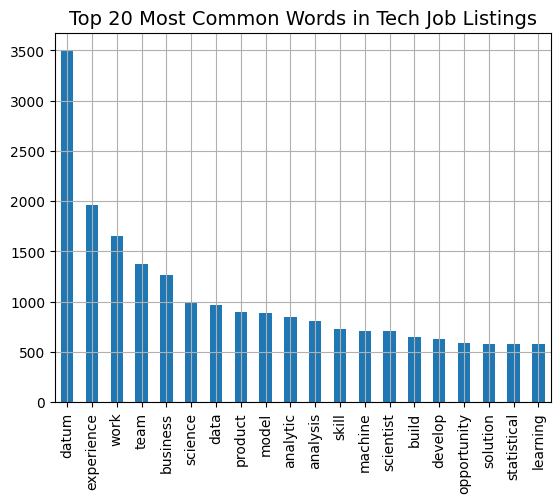

In [ ]:
###BEGIN SOLUTION
# COMPLETE THE CODE IN THIS CELL
top_n = 20
# sum the term counts in each column of the dtm_tf data frame and then sort in descending order
sorted_terms = dtm_tf.sum().sort_values(ascending=False)

plt.title("Top {} Most Common Words in Tech Job Listings".format(top_n), fontsize=14)
sorted_terms[:top_n].plot(kind='bar', grid=True)
###END SOLUTION

## 5) Use Scikit-Learn's `TfidfVectorizer` to get a TF-IDF feature matrix

- Instantiate a `TfidfVectorizer` object
- Pass the tokenizer that you created above as a parameter value into `TfidfVectorizer`
- Use `TfidfVectorizer` to create a *document-term matrix*
- Copy your *document-term matrix* into a `pandas` dataframe, getting the column names from the `TfidfVectorizer` object


In [ ]:
###BEGIN SOLUTION
tfidf = TfidfVectorizer(tokenizer=tokenizer, stop_words="english")
tfidf = tfidf.fit(df.clean_text)
dtm_tfidf = tfidf.transform(df.clean_text).toarray()
dtm_tfidf = pd.DataFrame(data=dtm_tfidf, columns=vect.get_feature_names_out())
###END SOLUTION

In [ ]:
dtm_tfidf_df = pd.DataFrame(data=dtm_tfidf, columns=vect.get_feature_names_out())

In [ ]:
dtm_tfidf_df

,aa,aap,ab,abernathy,ability,able,abound,abroad,absence,absolutely,...,zero,zeus,zf,zheng,zillow,zogsport,zone,zoom,zuckerberg,zurich
0,0.0,0.0,0.0,0.0,0.093586,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.021738,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.070346,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.11501,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0.0,0.0,0.0,0.0,0.029582,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
422,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
423,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.105612,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
424,0.0,0.0,0.0,0.0,0.000000,0.068204,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


Stretch: see if you can make a visualization of this TF-IDF Document-Term  matrix, as you did in Part 3 for the CountVectorizer Document-Term matrix, i.e. using a barplot.

## 6) Create a `NearestNeighbor` Model for the Data Science job listings
Write a some text that describes your ideal Data Science job, and query the model to identify jobs with similar descriptions!

In [ ]:
ideal_ds_job_query=["My ideal job is where I can scrub data from a company to help them be the most efficient helping them to find ways they can improve their company"]

In [ ]:
# vectorize your ideal job description using your fitted tfidf vectorizer
ideal_job_vector = tfidf.transform(ideal_ds_job_query).toarray()

# fit NearestNeighbors model to the Indeed reviews document-term matrix that you created
nn = NearestNeighbors(n_neighbors=top_n)
nn.fit(dtm_tfidf)

# get top_n_neigh distances and review indices for reviews that are closest to your ideal job
n_dist, n_ind = nn.kneighbors(ideal_job_vector)

# look at a few of the most similar job descriptions to your ideal job
# Did your query find good matches?
# YOUR CODE HERE


In [ ]:
n_dist[:5]

array([[1.32082204, 1.32183414, 1.33677903, 1.34187158, 1.34476359,
        1.34524004, 1.34524004, 1.34830594, 1.34853516, 1.3491495 ,
        1.34979133, 1.34979133, 1.35127761, 1.35553686, 1.35585604,
        1.35625545, 1.35625545, 1.35729894, 1.35729894, 1.35795904]])

In [ ]:
n_ind[:5]

array([[106,  59, 276, 299, 292, 365,  92, 387, 358, 327, 395, 155,  86,
         82, 284, 123,  23, 389, 233, 359]])

## Stretch Goals: do one of more of these that strike your fancy!

 - Repeat Part 6, but this time using spacy's word embeddings to represent documents as vectors. Remember, to form a document vector from spacy word embeddings, you average together the word embedding vectors of all the words in the document, so the document vector will have the same dimensionality as the word embeddings, namely 300 dimensions. Do you notice any difference in the results?
 - Watch Josh Starmer's video [StatQuest: Principal Component Analysis (PCA), Step-by-Step](https://www.youtube.com/watch?v=FgakZw6K1QQ). Or read [Daniela Witten's tweetstorm](https://twitter.com/womeninstat/status/1285610321747611653?lang=en) on Singular Value Decomposition (SVD). Now go back and review the section "Can we visualize word vectors?" from the [lecture video](https://drive.google.com/file/d/1QuwkO2Uj5sONFtqCk0_d2zrks2I6stkN/view?usp=sharing). Write a brief description of your understanding of Principal Components Analysis, and how it was used to visualize word vectors. Do your own experiments to explore relationships of words in two dimensions. Write a summary of what you discovered.

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings?
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. Hint: compose a query that references a number of tech stack items. How are those items distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this; algorithms that depend on Euclidean distance break down with high dimensional data. Do a bit of research to see if you can identify a suitable clustering algorithm.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for.